# Resevoir Sampling

We are going to perform the following actions:

1. Create our dataset and split it into test and training data.
2. Draw subsamples of the training data and save them as separate files on our harddrive.
3. Load these subsamples and train extremely randomized forest models on them.
4. Aggregate the models.
5. Check the results.

In [1]:
import numpy as np
from pandas import read_csv
from pandas import DataFrame, read_feather
import matplotlib.pyplot as plt
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.model_selection import train_test_split

## Defining Functions

In [2]:
# Define function to create new features the components of the "travel vector"
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #df['vector_modulus'] = np.sqrt(df.abs_diff_longitude**2 + df.abs_diff_latitude**2) # NOT PROPORTIONAL TO DIST

In [3]:
import math
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lng1, lat2, lng2):
    #return distance as meter if you want km distance, remove "* 1000"
    radius = 6371

    dLat = (lat2-lat1) * np.pi / 180
    dLng = (lng2-lng1) * np.pi / 180

    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180

    val = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLng/2) * np.sin(dLng/2) * np.cos(lat1) * np.cos(lat2)    
    ang = 2 * np.arctan2(np.sqrt(val), np.sqrt(1-val))
    return radius * ang

In [4]:
cols = ['fare_amount',
        'pickup_datetime',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        'passenger_count'
       ]

types = {
        'fare_amount': 'float32',
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'
        }

## Test Sample

In [5]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)
print(test_df.shape)
test_df.describe()

(9914, 7)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [6]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


In [7]:
test_dates = DataFrame()
test_dates['year'] = test_df['pickup_datetime'].dt.year #.astype('uint8')
test_dates['month'] = test_df['pickup_datetime'].dt.month #.astype('uint8')
test_dates['day'] = test_df['pickup_datetime'].dt.day #.astype('uint8')
test_dates['hour'] = test_df['pickup_datetime'].dt.hour #.astype('uint8')
test_dates['min'] = test_df['pickup_datetime'].dt.minute #.astype('uint8')
test_dates['second'] = test_df['pickup_datetime'].dt.second #.astype('uint8')
test_dates['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek #.astype('uint8')

test_dates.head()

,year,month,day,hour,min,second,dayofweek
0,2015,1,27,13,8,24,1
1,2015,1,27,13,8,24,1
2,2011,10,8,11,53,44,5
3,2012,12,1,21,12,12,5
4,2012,12,1,21,12,12,5


In [8]:
test_dates.describe()

,year,month,day,hour,min,second,dayofweek
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,2011.815816,6.857979,16.194170,13.467420,29.548416,16.610853,2.852834
std,1.803347,3.353272,8.838482,6.868584,18.674818,19.571034,1.994451
min,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,4.000000,9.000000,8.000000,13.000000,0.000000,1.000000
50%,2012.000000,7.000000,16.000000,15.000000,33.000000,6.000000,3.000000
75%,2014.000000,10.000000,25.000000,19.000000,45.000000,33.000000,5.000000
max,2015.000000,12.000000,31.000000,23.000000,59.000000,59.000000,6.000000


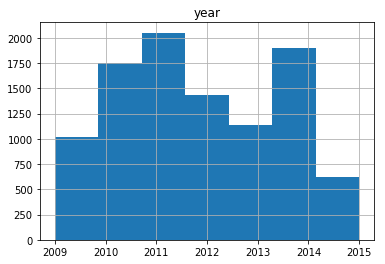

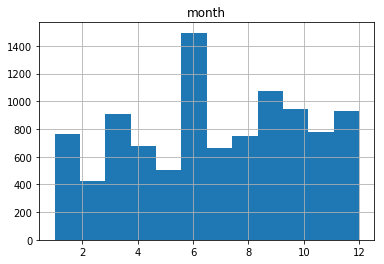

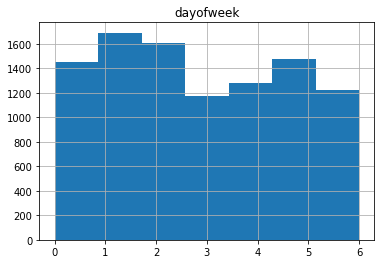

In [9]:
#test_dates.hist(column = ['year','month','day'])
test_dates.hist(column = ['year'],bins=7)
test_dates.hist(column = ['month'],bins=12)
test_dates.hist(column = ['dayofweek'],bins=7)
plt.show()

In [10]:
lng1min = test_df.pickup_longitude.min()
lng2min = test_df.dropoff_longitude.min()
lat1min = test_df.pickup_latitude.min()
lat2min = test_df.dropoff_latitude.min()
#
lng1max = test_df.pickup_longitude.max()
lng2max = test_df.dropoff_longitude.max()
lat1max = test_df.pickup_latitude.max()
lat2max = test_df.dropoff_latitude.max()

## Sample 1

In [11]:
#train_df = read_csv('train1M.csv', parse_dates=["pickup_datetime"],
#                    infer_datetime_format=True, usecols=cols)
train_df = read_feather('tmp/train100K.feather')
print(train_df.shape)
train_df.head()
#train_df.describe()

(100000, 7)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,10.5,2015-05-11 11:42:51,-73.978989,40.761620,-73.963959,40.770561,1
1,7.5,2013-10-20 13:27:00,-73.980347,40.763069,-73.988686,40.753979,2
2,4.5,2012-08-04 22:25:00,-74.002281,40.726578,-74.009583,40.723598,2
3,14.5,2011-10-22 23:12:35,-73.932800,40.758900,-73.995003,40.736599,1
4,13.0,2013-11-06 12:44:10,-73.975418,40.761070,-73.998444,40.724892,1


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
fare_amount          100000 non-null float32
pickup_datetime      100000 non-null datetime64[ns]
pickup_longitude     100000 non-null float32
pickup_latitude      100000 non-null float32
dropoff_longitude    100000 non-null float32
dropoff_latitude     100000 non-null float32
passenger_count      100000 non-null uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 2.8 MB


### Missing values

Let's check and remove missing values

In [13]:
#print(train_df.isnull().sum())
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 100000
New size: 100000


### passenger_count = 0 and passenger_count $\geq$ 6

Let's check and remove taxi rides with **passenger_count** = 0.

In [14]:
#print(train_df.isnull().sum())
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df['passenger_count'] >= 1) &
                    (train_df['passenger_count'] <= 6)]
train_df = train_df.drop(['passenger_count'], axis=1)
print('New size: %d' % len(train_df))

Old size: 100000
New size: 99661


### fare_amount < 0

Let's check and remove rows with negative values for **fare_amount**.

Old size: 99661
New size: 99659


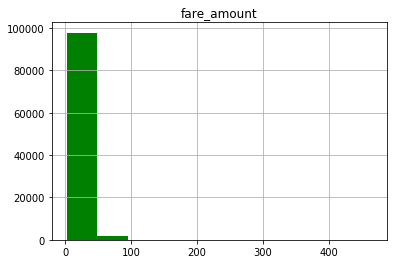

In [15]:
print('Old size: %d' % len(train_df))
#train_df = train_df[(train_df['fare_amount'] >= 1)]
train_df = train_df[(train_df['fare_amount'] >= 2.5) & (train_df['fare_amount'] <= 500)]
print('New size: %d' % len(train_df))
train_df.hist(column = ['fare_amount'], color = 'green')
plt.show()

### Latitude and Longitude - pickup_latitude = dropoff_latitude / pickup_longitude = dropoff_longitude

There are taxi rides with no coordinate changes. They seem normal rides though (see plots bellow). We can remove these rows since we are going to derive features from pickup and dropoff locations.

In [16]:
gps_fail = train_df[(train_df['pickup_latitude'] == train_df['dropoff_latitude']) &
                    (train_df['pickup_longitude'] == train_df['dropoff_longitude'])]
print('Number of taxi rides with no coordinate changes: %d' % len(gps_fail))

Number of taxi rides with no coordinate changes: 2819


In [17]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude']) &
                    (train_df['pickup_longitude'] != train_df['dropoff_longitude'])]
print('New size: %d' % len(train_df))

Old size: 99659
New size: 96764


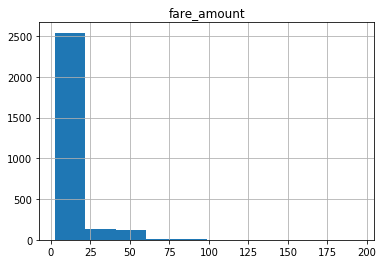

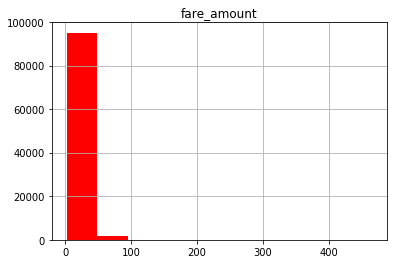

In [18]:
gps_fail.hist(column = ['fare_amount'])
train_df.hist(column = ['fare_amount'], color='red')
plt.show()

### Latitude and Longitude - Absurd displacements

There are absurd values for pickup and dropoff coordinates that are not present in the test set and should be removed. Minimum and maximum cuts should be suited to mimic the distributions in the test set.

Old size: 96764
New size: 96447


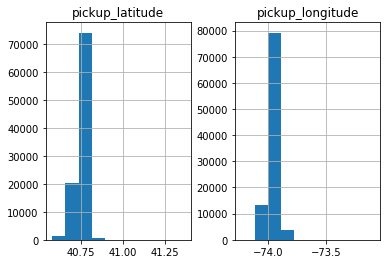

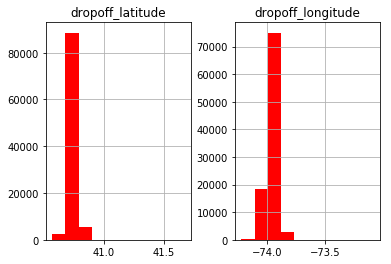

In [19]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df['pickup_longitude'] > lng2min) & (train_df['pickup_longitude'] < lng1max)]
train_df = train_df[(train_df['dropoff_longitude'] > lng2min) & (train_df['dropoff_longitude'] < lng1max)]
train_df = train_df[(train_df['pickup_latitude'] > lat2min) & (train_df['pickup_latitude'] < lat1max)]
train_df = train_df[(train_df['dropoff_latitude'] > lat2min) & (train_df['dropoff_latitude'] < lat1max)]
print('New size: %d' % len(train_df))
train_df.hist(column = ['pickup_longitude','pickup_latitude'])
train_df.hist(column = ['dropoff_longitude','dropoff_latitude'], color = 'red')
plt.show()

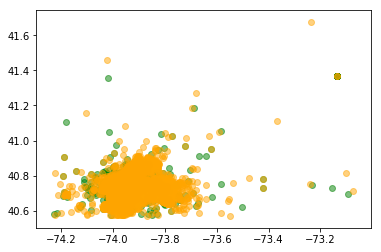

In [20]:
plt.scatter(train_df['pickup_longitude'], train_df['pickup_latitude'],
            color='green', alpha=0.5)
plt.scatter(train_df['dropoff_longitude'], train_df['dropoff_latitude'],
            color='orange', alpha=0.5)
plt.show()

In [21]:
# define bounding box
BB = (-75, -73, 40, 41.5)

# load image of NYC map
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-75_40_-73_41.5.png')

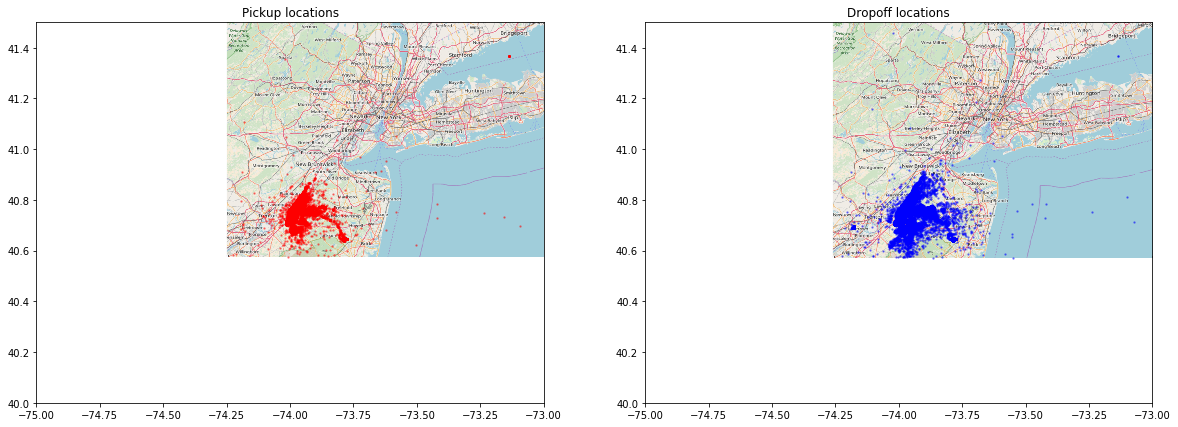

In [22]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, figsize=(20, 16)):
    fig, axs = plt.subplots(1,2, figsize=figsize)
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=0.4, c='r', s=2)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=[-75, -73, 40, 41.5]);

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=0.4, c='b', s=2)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=[-75, -73, 40, 41.5]);
    
plot_on_map(train_df, BB, nyc_map)

In [139]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.927387e+06,1.927387e+06,1.927387e+06,1.927387e+06,1.927387e+06
mean,1.130707e+01,-7.397542e+01,4.075101e+01,-7.397457e+01,4.075138e+01
std,9.505239e+00,3.559337e-02,2.760431e-02,3.452238e-02,3.100322e-02
min,2.500000e+00,-7.426114e+01,4.056911e+01,-7.426238e+01,4.056899e+01
25%,6.000000e+00,-7.399229e+01,4.073661e+01,-7.399159e+01,4.073570e+01
50%,8.500000e+00,-7.398211e+01,4.075343e+01,-7.398061e+01,4.075390e+01
75%,1.250000e+01,-7.396843e+01,4.076760e+01,-7.396554e+01,4.076842e+01
max,4.500000e+02,-7.299200e+01,4.162006e+01,-7.298820e+01,4.158635e+01


### New Features - Displacements

In [162]:
#add_travel_vector_features(train_df)
train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                            train_df['dropoff_latitude'], train_df['dropoff_longitude'])

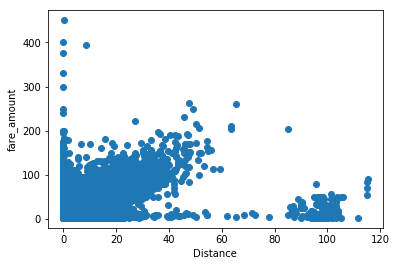

In [101]:
plt.scatter(train_df.dist, train_df.fare_amount)
plt.xlabel('Distance')
plt.ylabel('fare_amount')
plt.show()

### New Features - Dates

In [163]:
train_df['hour'] = train_df['pickup_datetime'].dt.hour.astype('uint8')
#train_df['month'] = train_df['pickup_datetime'].dt.month.astype('uint8')
#train_df['year'] = train_df['pickup_datetime'].dt.year
#train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek.astype('uint8')
#train_df = train_df.drop(['pickup_datetime'], axis=1)

In [142]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,hour
0,34.669998,2009-10-09 18:05:00,-73.870819,40.773991,-73.999054,40.760658,10.900634,18
1,4.000000,2014-03-25 18:08:00,-74.004051,40.752945,-74.001144,40.746910,0.714324,18
2,3.300000,2009-02-21 01:04:00,-73.980865,40.750500,-73.981079,40.755962,0.607685,1
3,7.300000,2011-10-17 20:28:11,-73.979965,40.743340,-73.988792,40.759567,1.951639,20
4,7.000000,2014-06-04 09:06:32,-73.993851,40.720497,-74.007256,40.726669,1.321783,9


# "Fare Periods" - before and after Aug/2012

In [174]:
P1 = train_df[(train_df['pickup_datetime'] < '2012-09-01')]
P1 = P1.drop(['pickup_datetime'], axis=1)
P2 = train_df.loc[(train_df['pickup_datetime'] >= '2012-09-01')]
P2 = P2.drop(['pickup_datetime'], axis=1)
#train_df = train_df.drop(['pickup_datetime'], axis=1)
print(P1.shape)
print(P2.shape)

(1099654, 7)
(827733, 7)


In [170]:
P1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099654 entries, 0 to 1999999
Data columns (total 7 columns):
fare_amount          1099654 non-null float32
pickup_longitude     1099654 non-null float32
pickup_latitude      1099654 non-null float32
dropoff_longitude    1099654 non-null float32
dropoff_latitude     1099654 non-null float32
dist                 1099654 non-null float32
hour                 1099654 non-null uint8
dtypes: float32(6), uint8(1)
memory usage: 34.6 MB


## Train the Model

In [175]:
from sklearn.model_selection import train_test_split
# Sample1
#xcols = ['pickup_longitude',
#        'pickup_latitude',
#        'dropoff_longitude',
#        'dropoff_latitude',
#        #'hour',
#        'dist']
X = P2.iloc[:,1:7].values
y = P2.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3, random_state=seed)


## XGBoosting

In [ ]:
import xgboost as xgb

def XGBmodel(X_train,X_test,y_train,y_test):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'},
                    dtrain=matrix_train,num_boost_round=100, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(X_train,X_test,y_train,y_test)

## GBM with warm_start

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Slower
model = GradientBoostingRegressor(n_estimators=20,random_state=seed,
                                  max_depth=15,learning_rate=.1,subsample=.5)
model.fit(X_train,y_train)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)).round(2), np.sqrt(np.std(scores))))
y_pred=model.predict(X_test)
print('RMSE(test): %.3f' % np.sqrt(mean_squared_error(y_pred,y_test)).round(3))

In [ ]:
def featureImp_order(model, X, k=5):
    return X[:,model.feature_importances_.argsort()[::-1][:k]]
newX = featureImp_order(model,X,2)
#print(newX)

# let's order the features in amount of importance
print(sorted(zip(map(lambda x: round(x, 4),
                     model.feature_importances_),xcols),reverse=True))

In [ ]:
# Faster
gbc = GradientBoostingRegressor(warm_start=True, learning_rate=.05,
                                 max_depth=15,random_state=seed)

for n_estimators in range(15, 20, 5):
    gbc.set_params(n_estimators=n_estimators)
    gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
print('RMSE(test): %.3f' % np.sqrt(mean_squared_error(y_pred,y_test)).round(3))
print(gbc.set_params)

## The Basic CV Approach

In [176]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(random_state=seed, n_estimators=25, n_jobs = -1, warm_start=True)
model.fit(X_train,y_train)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))

RMSE: 3.810 +/- 0.692


In [177]:
y_pred=model.predict(X_test)
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_pred,y_test)).round(3))

RMSE: 3.805


## The GridSearch Approach

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_dist = {"max_features": [3,4,5,6],
              "min_samples_split": [8,10,12],
              "min_samples_leaf": [4,5,6],
              "bootstrap": [True, False]}

rsearch = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20)
rsearch.fit(X_train,y_train)

In [ ]:
#rsearch.grid_scores_

In [ ]:
model=rsearch.best_estimator_
print(model)

In [ ]:
# Best model applyied on the test set
y_pred=model.predict(X_test)
np.sqrt(mean_squared_error(y_pred,y_test)).round(3)

## The Reservoir Sampling Approach

Let's use the results of the GridSearch above and vary **n_estimators** for the model aggregation, starting with **n_estimators = 10**. Let's conserve X_test, y_test to check the resutls.

In [ ]:
# Model obtained from GridSearchCV...
model = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=4,
          min_samples_split=10, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=101,
          verbose=0, warm_start=True)

model.fit(X_train,y_train)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))
print('Amount of trees in the model: %s' % len(model.estimators_))

## Sample 2

In [ ]:
# Read the training set
train_df = read_csv('train2.csv', parse_dates=["pickup_datetime"],
                    infer_datetime_format=True, usecols=cols, dtype=types)
# Remove missing values
train_df = train_df.dropna(how = 'any', axis = 'rows')
# Remove absurd passenger_count
train_df = train_df[(train_df['passenger_count'] >= 1) &
                    (train_df['passenger_count'] <= 6)]
# Remove negative and extreme fare_amount values
train_df = train_df[(train_df['fare_amount'] >= 3) & (train_df['fare_amount'] <= 150)]
# Remove no displacements
train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude']) &
                    (train_df['pickup_longitude'] != train_df['dropoff_longitude'])]
# Remove absurd displacements
train_df = train_df[(train_df['pickup_longitude'] > lng1min) & (train_df['pickup_longitude'] < lng1max)]
train_df = train_df[(train_df['dropoff_longitude'] > lng2min) & (train_df['dropoff_longitude'] < lng2max)]
train_df = train_df[(train_df['pickup_latitude'] > lat1min) & (train_df['pickup_latitude'] < lat1max)]
train_df = train_df[(train_df['dropoff_latitude'] > lat2min) & (train_df['dropoff_latitude'] < lat2max)]
# Create new features - dates
train_df['hour'] = train_df['pickup_datetime'].dt.hour #.astype('uint8')
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek #.astype('uint8')
train_df = train_df.drop(['pickup_datetime'], axis=1)
# Create new features - displacements
add_travel_vector_features(train_df)
train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                            train_df['dropoff_latitude'], train_df['dropoff_longitude'])

In [ ]:
# Sample2
X = train_df.iloc[:,[1,2,3,4,6,11]].values
y = train_df.iloc[:,0].values
model.set_params(n_estimators=15, random_state=101, n_jobs = -1, warm_start=True)
model.fit(X, y)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))
print('Amount of trees in the model: %s' % len(model.estimators_))

## Sample 3

In [ ]:
# Read the training set
train_df = read_csv('train3.csv', parse_dates=["pickup_datetime"],
                    infer_datetime_format=True, usecols=cols, dtype=types)
# Remove missing values
train_df = train_df.dropna(how = 'any', axis = 'rows')
# Remove absurd passenger_count
train_df = train_df[(train_df['passenger_count'] >= 1) &
                    (train_df['passenger_count'] <= 6)]
# Remove negative and extreme fare_amount values
train_df = train_df[(train_df['fare_amount'] >= 3) & (train_df['fare_amount'] <= 150)]
# Remove no displacements
train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude']) &
                    (train_df['pickup_longitude'] != train_df['dropoff_longitude'])]
# Remove absurd displacements
train_df = train_df[(train_df['pickup_longitude'] > lng1min) & (train_df['pickup_longitude'] < lng1max)]
train_df = train_df[(train_df['dropoff_longitude'] > lng2min) & (train_df['dropoff_longitude'] < lng2max)]
train_df = train_df[(train_df['pickup_latitude'] > lat1min) & (train_df['pickup_latitude'] < lat1max)]
train_df = train_df[(train_df['dropoff_latitude'] > lat2min) & (train_df['dropoff_latitude'] < lat2max)]
# Create new features - dates
train_df['hour'] = train_df['pickup_datetime'].dt.hour #.astype('uint8')
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek #.astype('uint8')
train_df = train_df.drop(['pickup_datetime'], axis=1)
# Create new features - displacements
add_travel_vector_features(train_df)
train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                            train_df['dropoff_latitude'], train_df['dropoff_longitude'])

In [ ]:
# Sample3
X = train_df.iloc[:,[1,2,3,4,6,11]].values
y = train_df.iloc[:,0].values
model.set_params(n_estimators=20, random_state=101, n_jobs = -1, warm_start=True)
model.fit(X, y)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))
print('Amount of trees in the model: %s' % len(model.estimators_))

## Sample 4

In [ ]:
# Read the training set
train_df = read_csv('train4.csv', parse_dates=["pickup_datetime"],
                    infer_datetime_format=True, usecols=cols, dtype=types)
# Remove missing values
train_df = train_df.dropna(how = 'any', axis = 'rows')
# Remove negative and extreme fare_amount values
train_df = train_df[(train_df['fare_amount'] > 3) & (train_df['fare_amount'] < 100.1)]
# Remove no displacements
train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude']) &
                    (train_df['pickup_longitude'] != train_df['dropoff_longitude'])]
# Remove absurd displacements
train_df = train_df[(train_df['pickup_latitude'] > 40.5) & (train_df['pickup_latitude'] < 41)]
train_df = train_df[(train_df['pickup_longitude'] > -74.4) & (train_df['pickup_longitude'] < -73.6)]
train_df = train_df[(train_df['dropoff_latitude'] > 40.5) & (train_df['dropoff_latitude'] < 41)]
train_df = train_df[(train_df['dropoff_longitude'] > -74.4) & (train_df['dropoff_longitude'] < -73.6)]
# Create new features - dates
train_df['hour'] = train_df['pickup_datetime'].dt.hour #.astype('uint8')
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek #.astype('uint8')
train_df = train_df.drop(['pickup_datetime'], axis=1)
# Create new features - displacements
add_travel_vector_features(train_df)
train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                            train_df['dropoff_latitude'], train_df['dropoff_longitude'])

In [ ]:
# Sample4
X = train_df.iloc[:,[1,2,3,4,6,11]].values
y = train_df.iloc[:,0].values
model.set_params(n_estimators=25, random_state=101, n_jobs = -1, warm_start=True)
model.fit(X, y)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))
print('Amount of trees in the model: %s' % len(model.estimators_))

## Sample 5

In [ ]:
# Read the training set
train_df = read_csv('train5.csv', parse_dates=["pickup_datetime"],
                    infer_datetime_format=True, usecols=cols, dtype=types)
# Remove missing values
train_df = train_df.dropna(how = 'any', axis = 'rows')
# Remove negative and extreme fare_amount values
train_df = train_df[(train_df['fare_amount'] > 3) & (train_df['fare_amount'] < 100.1)]
# Remove no displacements
train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude']) &
                    (train_df['pickup_longitude'] != train_df['dropoff_longitude'])]
# Remove absurd displacements
train_df = train_df[(train_df['pickup_latitude'] > 40.5) & (train_df['pickup_latitude'] < 41)]
train_df = train_df[(train_df['pickup_longitude'] > -74.4) & (train_df['pickup_longitude'] < -73.6)]
train_df = train_df[(train_df['dropoff_latitude'] > 40.5) & (train_df['dropoff_latitude'] < 41)]
train_df = train_df[(train_df['dropoff_longitude'] > -74.4) & (train_df['dropoff_longitude'] < -73.6)]
# Create new features - dates
train_df['hour'] = train_df['pickup_datetime'].dt.hour #.astype('uint8')
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek #.astype('uint8')
train_df = train_df.drop(['pickup_datetime'], axis=1)
# Create new features - displacements
add_travel_vector_features(train_df)
train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                            train_df['dropoff_latitude'], train_df['dropoff_longitude'])

In [ ]:
# Sample5
X = train_df.iloc[:,[1,2,3,4,6,11]].values
y = train_df.iloc[:,0].values
model.set_params(n_estimators=30, random_state=101, n_jobs = -1, warm_start=True)
model.fit(X, y)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))
print('Amount of trees in the model: %s' % len(model.estimators_))

In [ ]:
# Best model applyied on the test set
y_pred=model.predict(X_test)
np.sqrt(mean_squared_error(y_pred,y_test)).round(3)

## Make predictions on the test set

In [ ]:
cols = ['pickup_datetime',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        'passenger_count'
       ]

types = {
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
        }

In [ ]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)
print(test_df.shape)
test_df.describe()

### pickup_latitude = dropoff_latitude / pickup_longitude = dropoff_longitude

In [ ]:
gps_fail = test_df[(test_df['pickup_latitude'] == test_df['dropoff_latitude']) &
                    (test_df['pickup_longitude'] == test_df['dropoff_longitude'])]
print('Number of taxi rides with no coordinate changes: %d' % len(gps_fail))

In [ ]:
test_df['hour'] = test_df['pickup_datetime'].dt.hour #.astype('uint8')
test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek #.astype('uint8')
test_df = test_df.drop(['pickup_datetime'], axis=1)
add_travel_vector_features(test_df)
test_df['dist'] = distance(test_df['pickup_latitude'], test_df['pickup_longitude'],
                            test_df['dropoff_latitude'], test_df['dropoff_longitude'])
test_df.head()

In [ ]:
#test_df.dtypes

In [ ]:
X_testF = test_df.iloc[:,[1,2,3,4,6,11]]
y_predF = model.predict(X_testF).round(2)

In [ ]:
y_predF.min()

In [ ]:
# Write the predictions to a CSV file which we can submit to the competition.

submission = DataFrame(
    {'key': test_df.key, 'fare_amount': y_predF},
    columns = ['key', 'fare_amount'])

#submission.head()
submission.to_csv('submission.csv', index = False)